<a href="https://colab.research.google.com/github/nageshgurram12/problem_solving/blob/master/Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Data reference: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones 

Exploratory Analysis:

Modeling:

Results:


**Import the training data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import io
import pandas as pd
import numpy as np

original_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/DataSet_HAR.csv')

In [4]:
original_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0

Drop the 'subject' and 'Activity' columns before analysis.

In [3]:
activity_labels = original_data['Activity']
all_X_data = original_data.drop(columns=['Activity', 'subject'])


# Exploratory Analysis

1. Get the distribution of data size corresponding to each label to see the balance in data set.
2. Visualize the data by reducing X to two to three dimensions.

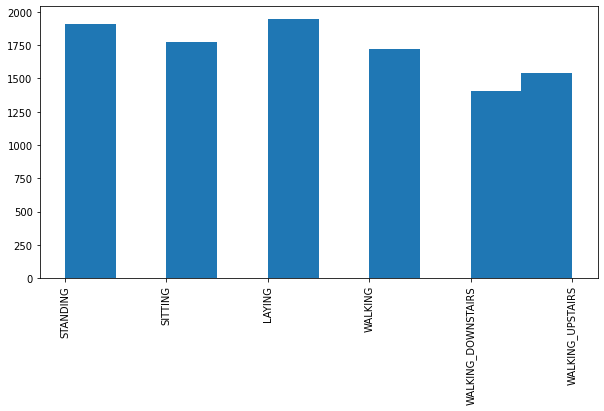

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plot_hist = plt.hist(activity_labels)

plt.xticks(rotation='vertical')
plt.show()

**Observation**: The data set is well balanced with respect to 'Activity' (y) label.

Now, lets visualize with PCA by reducing the dimensions to two (d=2).


In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_2d_X = pca.fit_transform(all_X_data)

Lets compare the shapes of the original data and compressed data:

In [65]:
print(all_X_data.shape, pca_2d_X.shape)

(10299, 561) (10299, 2)


The original data had 561 features and compressed data now has only 2 features. Now, this can be used to visualize in 2D plane.

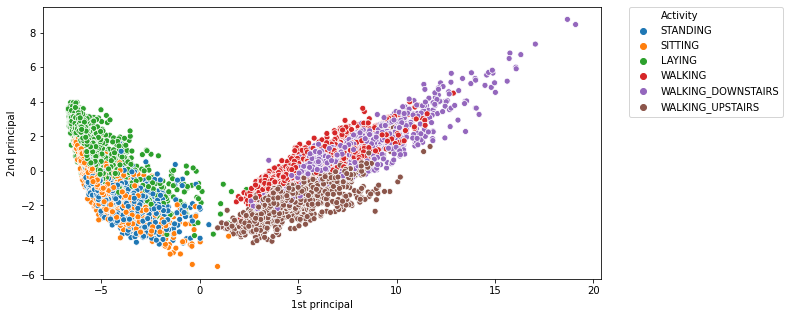

In [66]:
import seaborn as sns
sns.scatterplot(x=pca_2d_X[:, 0], y=pca_2d_X[:, 1], hue=activity_labels)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("1st principal"); plt.ylabel("2nd principal")
plt.show()

***Observation***: From the above plot, we can see that all the points when a person is walking is oriented to one side and sitting, laying and standing (motion less) postures data is to the other side. This is true because of accelerometer calibration shows different when person is moving and staying idle. 

From this we can say that accelerometer plays an important role in determing the posture of the person.

Now, lets visualize with an another visualizing technique for high dimensional data. t-SNE tries to maintain the local similarities in the data while reducing the dimensions. 

Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

If we run t-SNE on whole dataset it may run very slow, so lets reduce the feature dimension first by running PCA and then do t-SNE on sub smaple of original data.

In [67]:
from sklearn.manifold import TSNE

pca = PCA(n_components=50)
pca_50d_X = pca.fit_transform(all_X_data)
t_sne = TSNE(n_components=2, n_jobs=2)
tsne_2d_X = t_sne.fit_transform(pca_50d_X)

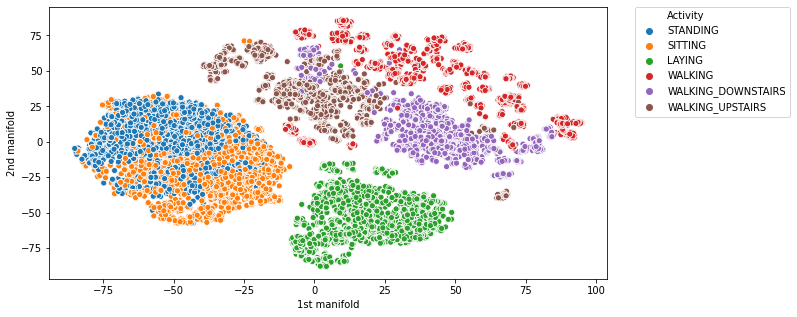

In [20]:
sns.scatterplot(x=tsne_2d_X[:, 0], y=tsne_2d_X[:, 1], hue=activity_labels)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("1st manifold"); plt.ylabel("2nd manifold")
plt.show()

**Observation**: We can see from the above plot, t-SNE is able to learn better non-linear manifolds which seperate the data more clearly.

# Data preprocessing

Lets encode the activity lables:
* 'LAYING', - 0

* 'SITTING', - 1

* 'STANDING' - 2

* 'WALKING' - 3

* 'WALKING_DOWNSTAIRS' - 4

* 'WALKING_UPSTAIRS' - 5

In [4]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(activity_labels)
all_y_data = label_encoder.transform(activity_labels)

**Train/Test split:**

Lets divide the data into train and test splits in 0.8, 0.2 ratio.

As we have six classes, when we do sampling for train, test datasets its important to do stratified sampling to get even proportions across the classes.

In [5]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(all_X_data, all_y_data, 
                                                            test_size=0.2, random_state=0, stratify=all_y_data)

Lets verify the class proportions in train, test datasets.

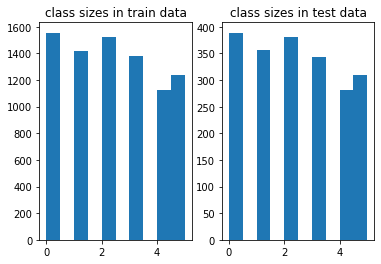

In [6]:
import matplotlib.pyplot as plt
fig, (ax_train, ax_test) = plt.subplots(1, 2)
ax_train.hist(train_y); ax_train.set_title("class sizes in train data");
ax_test.hist(test_y); ax_test.set_title("class sizes in test data")
plt.show()

# Modeling

**GradientBoostingClassifier** is an ensemble technique that boosts the week learners at every stage to make correct predictions for the misclassified samples in the previous stage.

HistGradientBoostingClassifier is faster version of Gradient Boosting and is implemented at [LightBGM](https://github.com/Microsoft/LightGBM)



In [22]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
gb_classifier = HistGradientBoostingClassifier(random_state=0) # default hyper-params
gb_classifier.fit(train_X, train_y)

HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.1,
                               loss='auto', max_bins=255, max_depth=None,
                               max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=0, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

Accuracy and confusion matrix for gradient boosting classifier.

In [24]:
test_y_predict = gb_classifier.predict(test_X)
from sklearn.metrics import accuracy_score, plot_confusion_matrix
print("Gradient boost classifier accuracy: " + str(accuracy_score(test_y, test_y_predict)))


Accuracy: 0.9932038834951457


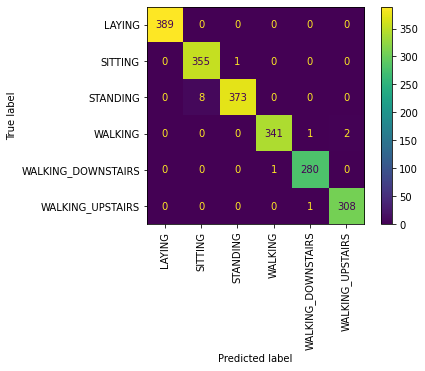

In [34]:
plot_confusion_matrix(gb_classifier, test_X, test_y, display_labels=label_encoder.classes_,
                      xticks_rotation="vertical", values_format="d")
plt.show()

**Random Forest Classifer**

This is also an ensemble technique like above, but here we use bagging technique to take average of the multiple moderate learners (decision trees) to reduce the variance and thus by reducing over-fitting.

*Documentation:*

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.


In [34]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=0, n_jobs=2)
rf_classifier.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Accuracy and confusion matrix for random forest classifer.

In [35]:
test_y_predict = rf_classifier.predict(test_X)
from sklearn.metrics import accuracy_score, plot_confusion_matrix
print("Random Forest classifier accuracy: " + str(accuracy_score(test_y, test_y_predict)))

Random Forest classifer accuracy: 0.9815533980582525


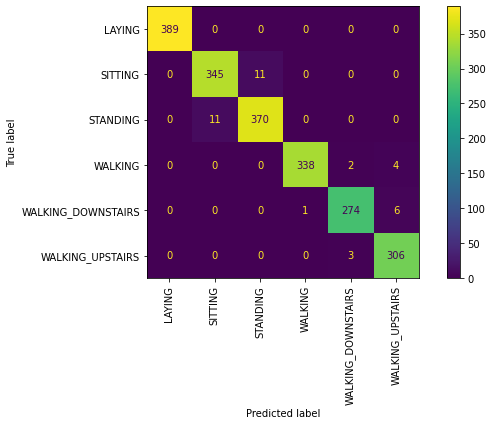

In [36]:
plot_confusion_matrix(rf_classifier, test_X, test_y, display_labels=label_encoder.classes_,
                      xticks_rotation="vertical", values_format="d")

Plot a bar chart with feature importance score from Random Forest classfier.

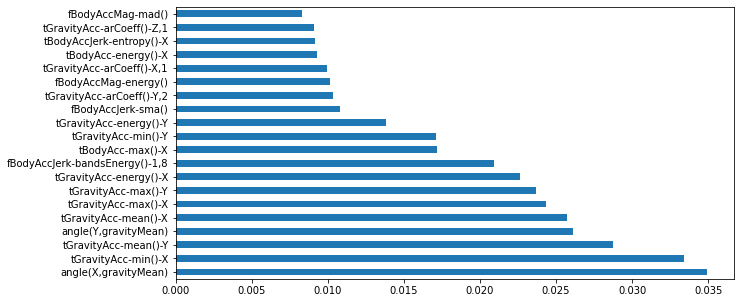

In [37]:
rf_feat_importances = pd.Series(rf_classifier.feature_importances_, index=all_X_data.columns)
rf_feat_importances.nlargest(20).plot(kind='barh')

Plot the accuracy vs the number of features needed by using feature importance metric from Random Forest classifier attributes.

We'll take features based on the 'impurity' measure calculated while constructing the random forest. 
At every step, we take n features based on the score and get a new accuracy score.

In [54]:
from sklearn.feature_selection import SelectFromModel
features_count = [*range(1, 10)]
accuracies = []

for fc in features_count:
  selector = SelectFromModel(rf_classifier, prefit=True, max_features=fc, threshold=-np.inf)
  reduced_train_X = selector.transform(train_X)
  reduced_test_X = selector.transform(test_X)
  rf_classifier_on_reduced_X = RandomForestClassifier(random_state=0, n_jobs=2)
  rf_classifier_on_reduced_X.fit(reduced_train_X, train_y)
  test_y_predict = rf_classifier_on_reduced_X.predict(reduced_test_X)
  accuracy = accuracy_score(test_y, test_y_predict)
  accuracies.append(accuracy)

(8239, 1)
0.4228155339805825 1
(8239, 2)
0.6810679611650485 2
(8239, 3)
0.845631067961165 3
(8239, 4)
0.8427184466019417 4
(8239, 5)
0.85 5
(8239, 6)
0.8640776699029126 6
(8239, 7)
0.8771844660194175 7
(8239, 8)
0.8766990291262136 8
(8239, 9)
0.9412621359223301 9


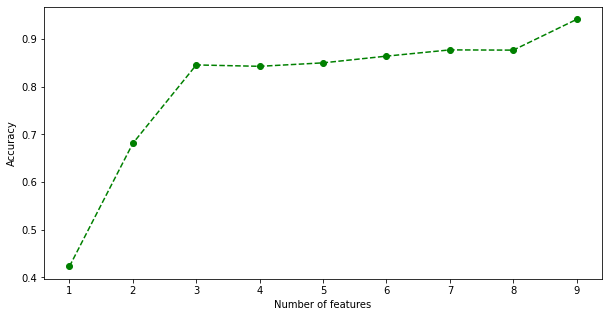

In [56]:
plt.plot(features_count, accuracies, 'go--')
plt.xlabel("Number of features"); plt.ylabel("Accuracy")
plt.show()

**Observation:** From the above plot, we can see that only 2 features are needed for getting 80% accuracy and 9 features are required out of 561 to get 90% accuracy.

These important features can be seen from the bar plot of feature importance scores.

# PCA

By using the PCA, lets find the most important information in the features to get atleast 90% accuracy.

In [60]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

n_pricipal_components = np.linspace(1, 10, 5, dtype=int)
accuracies = []

for n_pc in n_pricipal_components:
  pca = PCA(n_components=n_pc)
  reduced_train_X = pca.fit_transform(train_X)
  rf_classifier_on_reduced_X = RandomForestClassifier(random_state=0, n_jobs=2)
  rf_classifier_on_reduced_X.fit(reduced_train_X, train_y)

  reduced_test_X = pca.transform(test_X)
  test_y_predict = rf_classifier_on_reduced_X.predict(reduced_test_X)
  accuracy = accuracy_score(test_y, test_y_predict)
  accuracies.append(accuracy)

1 0.4097087378640777
3 0.7708737864077669
5 0.8446601941747572
7 0.8878640776699029
10 0.904368932038835


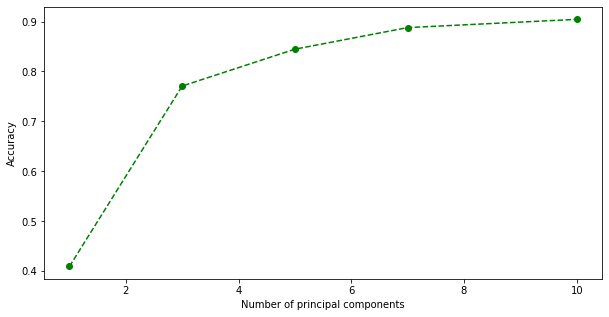

In [61]:
plt.plot(n_pricipal_components, accuracies, 'go--')
plt.xlabel("Number of principal components"); plt.ylabel("Accuracy")
plt.show()

**Observation**: From the above plot, we can see only the first 10 principal components can explain the enough variance in the data to get accuracy of 0.9.